# Setup

In [ ]:
!pip install finlab_crypto > log.txt
!pip install talib-binary > log.txt

import finlab_crypto
finlab_crypto.setup()

ohlcv = finlab_crypto.crawler.get_all_binance('BTCUSDT', '4h')

|------------------------------
| Google Drive not connected!  
|------------------------------
|
| Please connect google drive:
Mounted at /content/drive
All caught up..!


# Get SOPR

In [ ]:
from finlab_crypto.crawler import GlassnodeClient
from datetime import timezone
import datetime


def get_glassnode(url, api_key, index):

    gn = GlassnodeClient()
    gn.api_key = api_key
    ret = gn.get(url)
    ret.index = ret.index + datetime.timedelta(days=1)
    ret.index = ret.index.tz_localize(timezone.utc)
    ret = ret.reindex(index, method='ffill').ffill()
    return ret.astype(float)

sopr = get_glassnode('https://api.glassnode.com/v1/metrics/indicators/sopr',
                     'c5846d6e-b7ed-4d84-9339-03e88e6db3af', index=ohlcv.index)

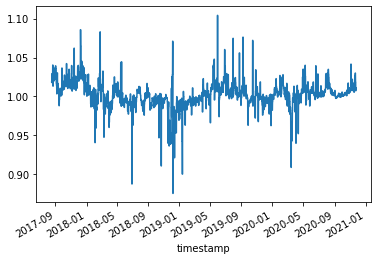

In [ ]:
sopr.plot()

# SOPR Strategy

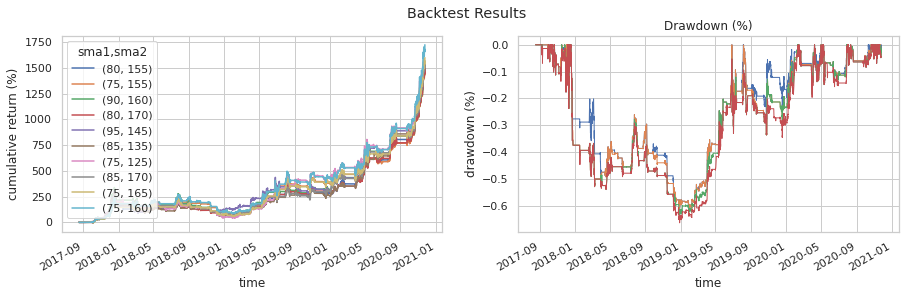

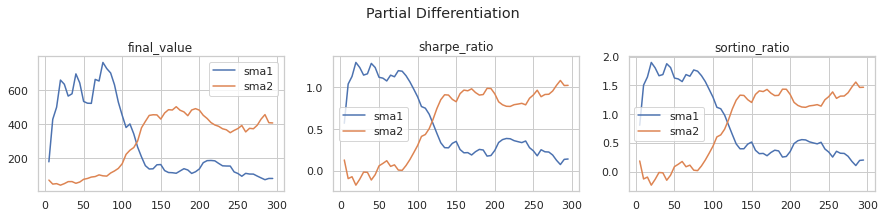

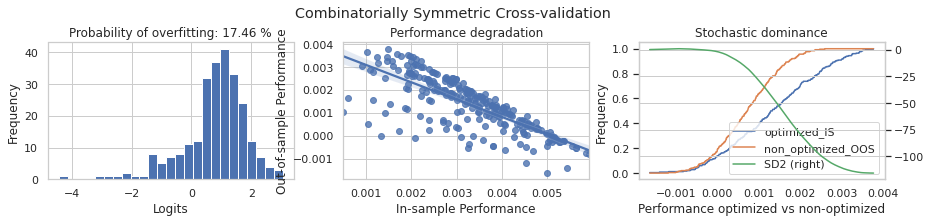

Output()

In [ ]:
import numpy as np
from finlab_crypto import Strategy

@Strategy(sma1=200, sma2=300)
def sopr_strategy(ohlcv):

    sma1 = sopr.rolling(sopr_strategy.sma1).mean()
    sma2 = sopr.rolling(sopr_strategy.sma2).mean()

    entries = (sma1 > sma2) & (sma1.shift() < sma2.shift())
    exits = (sma1 < sma2) & (sma1.shift() > sma2.shift())

    figures = {
        'figures':{
            'sopr': {
                'value': sopr-1,
                'sma1': sma1-1,
                'sma2': sma2-1,
            }
        }
    }

    return entries, exits, figures

portfolio = sopr_strategy.backtest(ohlcv, {
    'sma1': np.arange(5, 300, 5),
    'sma2': np.arange(5, 300, 5),
    #'sma1': 80,
    #'sma2': 160,
}, freq='4h', plot=True)